### Impoprt Section

In [27]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
import ast
import numpy as np
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar

from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol, order_value
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt

import quantstats as qs
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission

In [2]:
bundle = 'snp500'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
tickers = [coin.symbol for coin in assets]

In [3]:
data = pd.read_csv('price_by_prphet_etna.csv',index_col=0)
data

,AAPL,AMZN,GOOGL,MSFT,TSLA
timestamp,,,,,
2018-04-11,41.732859,69.573391,49.740199,89.893124,18.299433
2018-04-12,41.834317,68.910907,49.711924,89.785710,18.317717
2018-04-13,41.826657,69.408024,50.512207,90.265297,18.474969
2018-04-14,42.127574,68.772377,50.124684,90.347347,18.549962
2018-04-15,42.304194,68.778095,50.571658,90.383293,18.611702
...,...,...,...,...,...
2023-06-25,167.402489,107.266698,109.960276,311.677923,146.834335
2023-06-26,168.296920,106.943940,110.919265,313.019501,148.143752
2023-06-27,169.274921,107.908689,112.024663,312.477668,150.399746


In [4]:
returns = data.pct_change()
returns=returns[1:]

In [5]:
returns.index=pd.to_datetime(returns.index)

In [49]:
returns

,AAPL,AMZN,GOOGL,MSFT,TSLA
timestamp,,,,,
2018-04-12,0.002431,-0.009522,-0.000568,-0.001195,0.000999
2018-04-13,-0.000183,0.007214,0.016098,0.005341,0.008585
2018-04-14,0.007194,-0.009158,-0.007672,0.000909,0.004059
2018-04-15,0.004193,0.000083,0.008917,0.000398,0.003328
2018-04-16,0.000910,0.003210,-0.012144,0.004103,-0.003315
...,...,...,...,...,...
2023-06-25,-0.001069,0.002331,-0.007392,0.005821,0.006495
2023-06-26,0.005343,-0.003009,0.008721,0.004304,0.008918
2023-06-27,0.005811,0.009021,0.009966,-0.001731,0.015228


### Rough Backtest settion

In [68]:
def initialize(context):
     # Load the returns dataframe
    context.returns = returns

    # Define the assets (column names) to trade
    context.assets = context.returns.columns.tolist()

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'

 
def handle_data(context, data):
    for asset in context.assets:
        today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
        print (today_return)
        tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        # Get the return for tomorrow
        tomorrow_return = context.returns.loc[tomorrow_date, asset]

        # Buy if return is positive, sell if negative
        if tomorrow_return > 0:
            order_value(symbol(asset), 1000)
            print('buy', asset)
        else:
            order_value(symbol(asset), -1000)
            print('sell', asset)

In [71]:
def initialize(context):
     # Load the returns dataframe
    context.returns = returns

    # Define the assets (column names) to trade
    context.assets = context.returns.columns.tolist()

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    context.take_profit_long, context.take_profit_short  = 0.04, 0.04
    context.stop_loss_long, context.stop_loss_short = 0.03, 0.03
 
def handle_data(context, data):
    for asset in context.assets:
        today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
        tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        # Get the return for tomorrow
        tomorrow_return = context.returns.loc[tomorrow_date, asset]
        print(tomorrow_return)
        # Buy if return is positive, sell if negative
        if tomorrow_return > 0:
            order_value(symbol(asset), 1000)
            print('buy', asset)
        else:
            order_value(symbol(asset), -1000)
            print('sell', asset)
    for asset in context.portfolio.positions:
            current_price = data.current(asset, 'price')
            cost_basis = context.portfolio.positions[asset].cost_basis
            amount = context.portfolio.positions[asset].amount
            if amount > 0:
                if current_price >= cost_basis * (1 + context.take_profit_long):
                    order_target_percent(asset, 0)
                    print('stoploss')
                elif current_price <= cost_basis * (1 - context.stop_loss_long):
                    order_target_percent(asset, 0)
                    print('stoploss')
            elif amount < 0:
                if current_price >= cost_basis * (1 + context.stop_loss_short):
                    order_target_percent(asset, 0)
                    print('stoploss')
                elif current_price <= cost_basis *  (1 - context.take_profit_short):
                    order_target_percent(asset, 0)
                    print('stoploss')

In [72]:
start = '2018-04-13'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

0.007194385359786226
buy AAPL
-0.009158123798941098
sell AMZN
-0.007671876714403281
sell GOOGL
0.0009089849780397063
buy MSFT
0.00405919068050431
buy TSLA
0.0117329599521796
buy AAPL
0.012251104524005463
buy AMZN
0.00400731984575553
buy GOOGL
0.003654500338296396
buy MSFT
0.0021812449672926615
buy TSLA
0.0055888066497362665
buy AAPL
0.0029299808434011254
buy AMZN
0.009417575535656697
buy GOOGL
0.01396938799709968
buy MSFT
-0.003327851934157744
sell TSLA
0.0068103371523864364
buy AAPL
0.0020202280912002823
buy AMZN
0.0026573017141537925
buy GOOGL
0.001048221790685533
buy MSFT
-0.0013306553367802287
sell TSLA
0.0026803681677576296
buy AAPL
0.010774363992461566
buy AMZN
0.006747219325042408
buy GOOGL
0.012731397949795165
buy MSFT
0.00903812139657556
buy TSLA
-0.0047212262717990505
sell AAPL
-0.003588868453508254
sell AMZN
0.0042565910851302124
buy GOOGL
0.002032234789774545
buy MSFT
0.0028335992093124762
buy TSLA
stoploss
-0.005557224758075074
sell AAPL
0.0220680800958708
buy AMZN
0.00256

<AxesSubplot:>

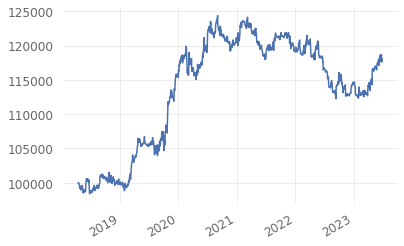

In [73]:
results.portfolio_value.plot()

<AxesSubplot:>

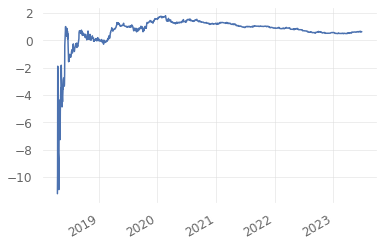

In [74]:
results.sharpe.plot()

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-16   2018-04-16
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             67.0%        100.0%

Cumulative Return          64.18%       18.01%
CAGR﹪                     6.8%         2.22%

Sharpe                     0.56         0.61
Prob. Sharpe Ratio         90.61%       91.98%
Smart Sharpe               0.54         0.59
Sortino                    0.84         0.9
Smart Sortino              0.8          0.87
Sortino/√2                 0.59         0.64
Smart Sortino/√2           0.57         0.61
Omega                      1.12         1.12

Max Drawdown               -27.32%      -9.73%
Longest DD Days            472          1029
Volatility (ann.)          20.63%       5.41%
R^2                        0.0          0.0
Information Ratio          -0.02        -0.02
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-09-03,2022-09-12,2023-06-28,1029,-9.726998,-9.474969
2,2020-02-20,2020-04-21,2020-06-08,109,-4.044009,-3.587185
3,2018-10-25,2019-01-29,2019-03-08,135,-2.663492,-2.241284
4,2019-06-04,2019-08-23,2019-09-18,107,-2.592995,-2.474152
5,2019-09-27,2019-10-02,2019-10-10,14,-2.591753,-2.022020


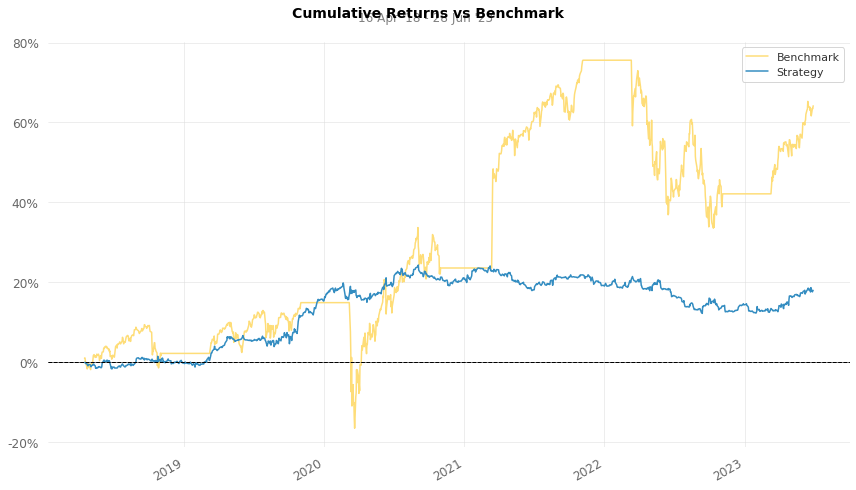

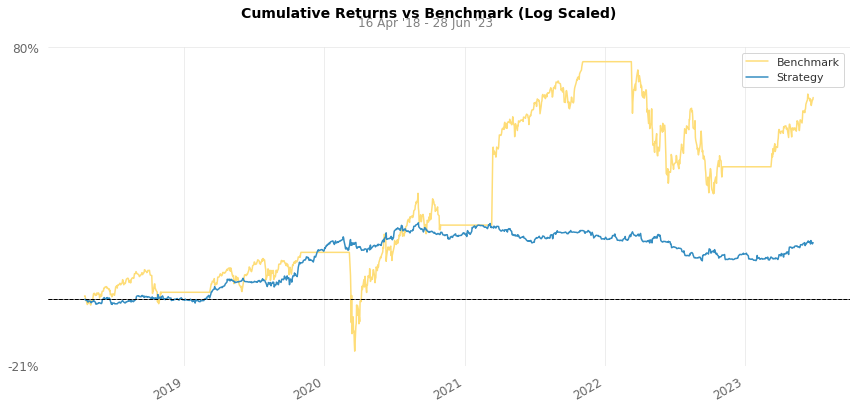

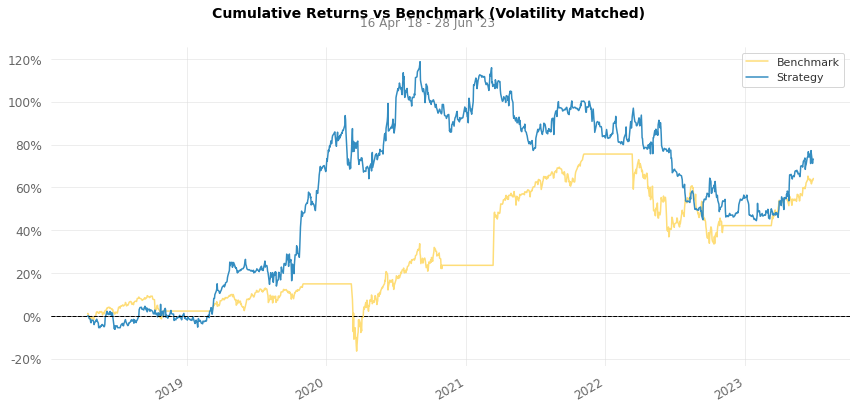

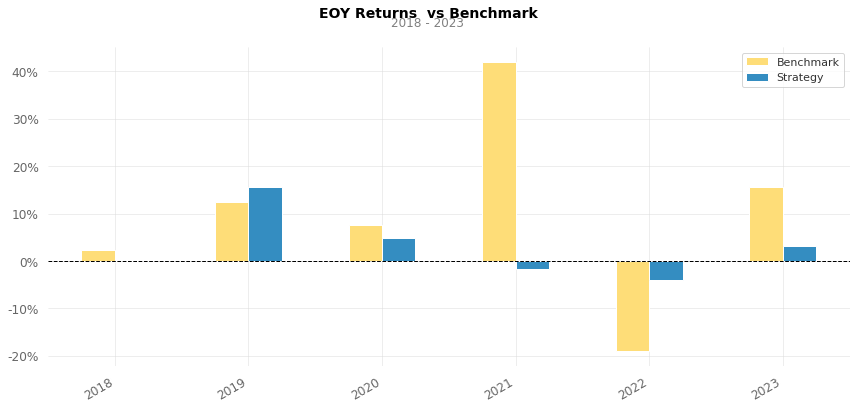

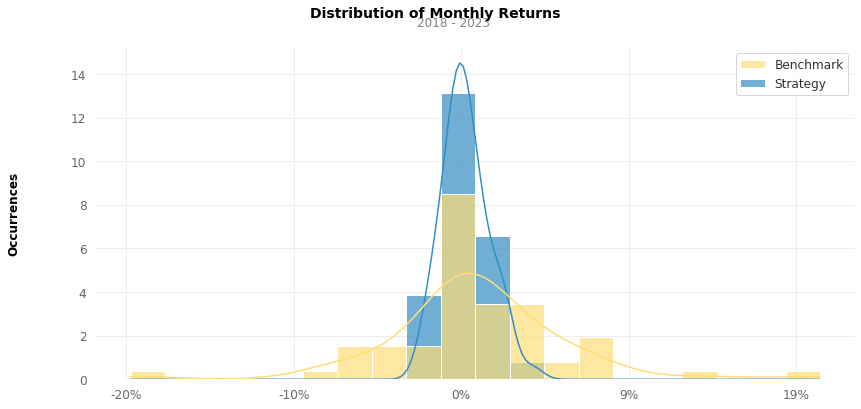

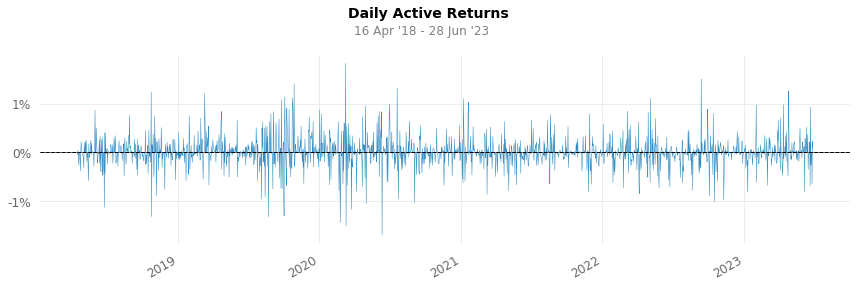

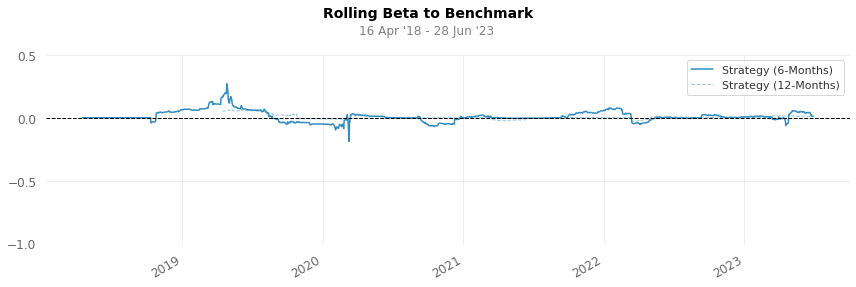

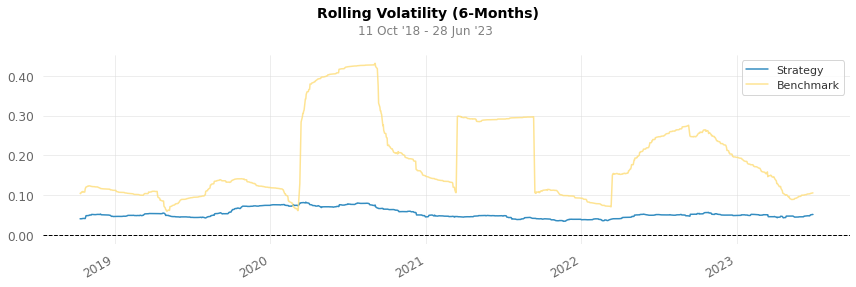

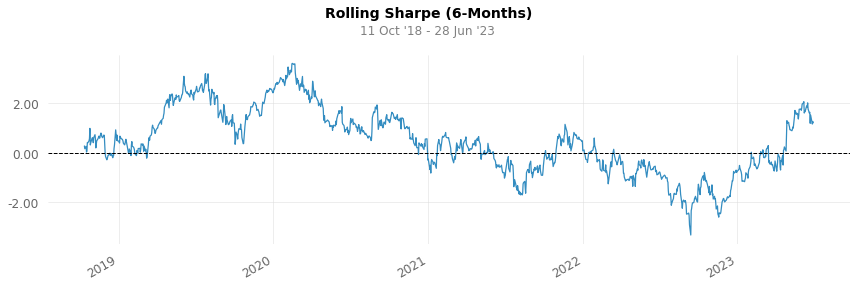

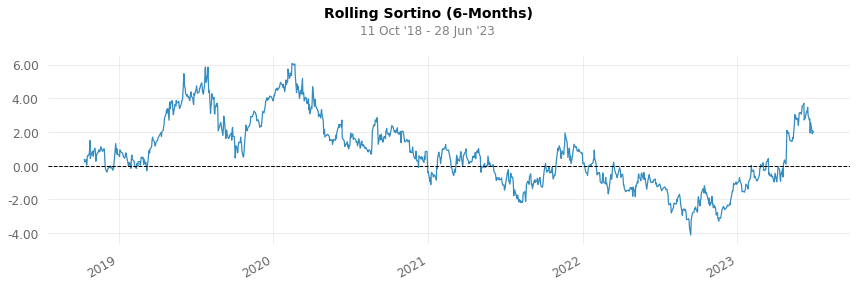

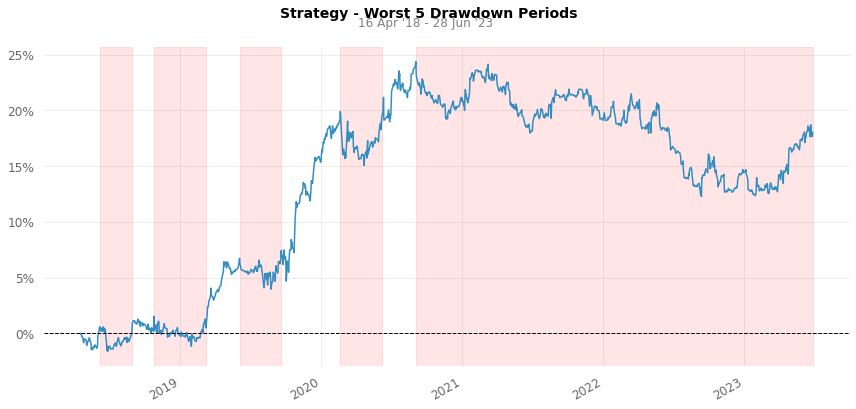

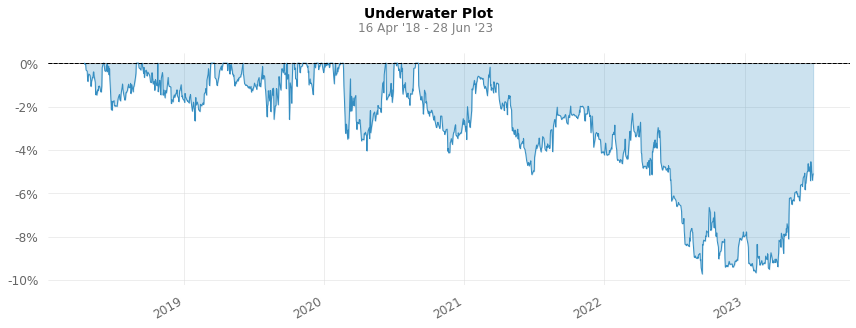

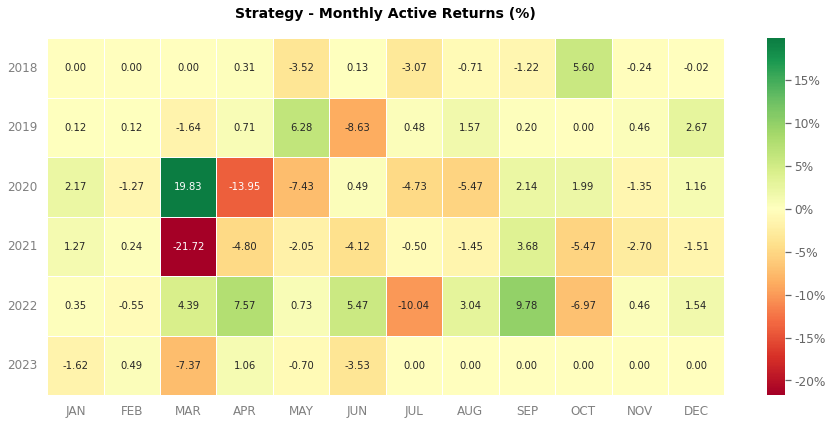

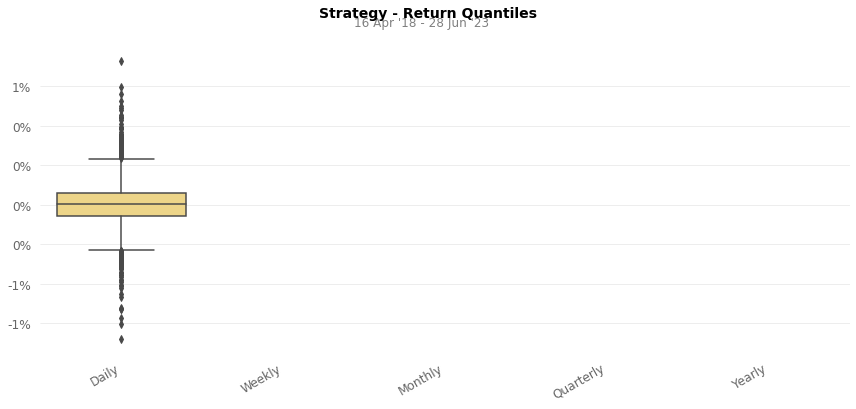

In [75]:
benchmark = qs.utils.download_returns('^GSPC', period="max")
results.index = pd.to_datetime(results.index).tz_convert(None)
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(12, 6))

Now the backtest will be based on 10 stocks from snp5600, 5 are from Technology and 5 from Healthcare sector. This time prophet prediction is based on 100 day before the predicted day. And also the trade will be based on the next day's return predictions.

In [4]:
data = pd.read_csv('price_by_prphet_etna.csv',index_col=0)
data

,AAPL,ABBV,ADSK,ALGN,BIO,GRMN,INCY,MDT,MSFT,TEL
timestamp,,,,,,,,,,
2018-04-11,41.732859,85.900736,126.661090,246.951419,243.326728,58.318981,74.904841,77.828607,89.893124,96.062725
2018-04-12,41.815973,85.164389,126.311890,252.615826,241.657583,58.142143,71.875594,77.778862,89.690405,95.733085
2018-04-13,41.825633,86.838710,127.299707,255.518451,242.186950,58.496782,70.264930,77.684116,90.149816,96.294387
2018-04-14,42.296707,85.677487,126.364541,253.965214,241.796903,58.612330,71.204426,78.165117,90.183361,96.297788
2018-04-15,42.498866,85.840430,126.241772,253.905744,241.935796,58.705765,70.272448,78.198413,90.818295,96.381729
...,...,...,...,...,...,...,...,...,...,...
2023-06-25,186.302304,137.820344,212.227103,336.500022,369.344761,105.128115,62.482658,88.803921,338.756388,136.535530
2023-06-26,187.855436,138.097849,214.137110,339.771669,366.009280,105.591094,62.645155,90.153836,341.794632,137.793509
2023-06-27,187.441287,136.849578,211.489144,338.518983,363.822555,104.827779,61.813481,89.588241,338.799850,137.225851


In [5]:
returns = data.pct_change()
returns=returns[1:]

In [8]:
returns.index=pd.to_datetime(returns.index)
returns

,AAPL,ABBV,ADSK,ALGN,BIO,GRMN,INCY,MDT,MSFT,TEL
timestamp,,,,,,,,,,
2018-04-12,0.001992,-0.008572,-0.002757,0.022937,-0.006860,-0.003032,-0.040441,-0.000639,-0.002255,-0.003432
2018-04-13,0.000231,0.019660,0.007820,0.011490,0.002191,0.006100,-0.022409,-0.001218,0.005122,0.005863
2018-04-14,0.011263,-0.013372,-0.007346,-0.006079,-0.001611,0.001975,0.013371,0.006192,0.000372,0.000035
2018-04-15,0.004780,0.001902,-0.000972,-0.000234,0.000574,0.001594,-0.013089,0.000426,0.007040,0.000872
2018-04-16,0.001592,-0.008020,0.007284,-0.005295,0.000568,-0.002659,-0.033531,-0.000537,0.006516,-0.002322
...,...,...,...,...,...,...,...,...,...,...
2023-06-25,0.001517,0.000816,0.001668,0.003519,0.001310,-0.001570,0.002943,0.006468,0.002278,0.002533
2023-06-26,0.008337,0.002014,0.009000,0.009723,-0.009031,0.004404,0.002601,0.015201,0.008969,0.009214
2023-06-27,-0.002205,-0.009039,-0.012366,-0.003687,-0.005975,-0.007229,-0.013276,-0.006274,-0.008762,-0.004120


In [13]:
returns.describe()

,AAPL,ABBV,ADSK,ALGN,BIO,GRMN,INCY,MDT,MSFT,TEL
count,1905.000000,1905.000000,1905.000000,1905.000000,1905.000000,1905.000000,1905.000000,1905.000000,1905.000000,1905.000000
mean,0.000833,0.000260,0.000322,0.000323,0.000251,0.000333,-0.000061,0.000089,0.000727,0.000224
std,0.008706,0.007262,0.010200,0.017426,0.009342,0.007782,0.009011,0.006515,0.006935,0.008415
min,-0.032916,-0.038240,-0.047167,-0.077787,-0.037443,-0.037068,-0.040441,-0.036079,-0.027841,-0.061148
25%,-0.003626,-0.003719,-0.005444,-0.008144,-0.005088,-0.003846,-0.005555,-0.003397,-0.002971,-0.004036
50%,0.001080,0.000310,0.000717,0.000671,0.000353,0.000533,0.000144,0.000096,0.000917,0.000262
75%,0.005912,0.004298,0.006179,0.009120,0.005905,0.004576,0.005075,0.003800,0.004844,0.004409
max,0.038044,0.045695,0.047506,0.144961,0.046374,0.044393,0.050019,0.037582,0.036386,0.062705


In [14]:
def initialize(context):
     # Load the returns dataframe
    context.returns = returns

    # Define the assets (column names) to trade
    context.assets = context.returns.columns.tolist()

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    context.take_profit_long, context.take_profit_short  = 0.04, 0.04
    context.stop_loss_long, context.stop_loss_short = 0.03, 0.03
 
def handle_data(context, data):
    for asset in context.assets:
        if asset == 'AAPL':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.003626:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'ABBV':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.003719	:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'ADSK':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.005444:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'ALGN':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.05:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.008144:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'BIO':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.005088:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'GRMN':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.003846:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'INCY':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.005555:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'MDT':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.003397:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'MSFT':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.002971:
                order_value(symbol(asset), -1000)
                print('sell', asset)
        elif asset == 'TEL':
            # today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
            tomorrow_date = (context.get_datetime() + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

            # Get the return for tomorrow
            tomorrow_return = context.returns.loc[tomorrow_date, asset]
            print(tomorrow_return)
            # Buy if return is positive, sell if negative
            if tomorrow_return > 0.01:
                order_value(symbol(asset), 1000)
                print('buy', asset)
            elif tomorrow_return<-0.004036:
                order_value(symbol(asset), -1000)
                print('sell', asset)
    for asset in context.portfolio.positions:
            current_price = data.current(asset, 'price')
            cost_basis = context.portfolio.positions[asset].cost_basis
            amount = context.portfolio.positions[asset].amount
            if amount > 0:
                if current_price >= cost_basis * (1 + context.take_profit_long):
                    order_target_percent(asset, 0)
                    print('stoploss')
                elif current_price <= cost_basis * (1 - context.stop_loss_long):
                    order_target_percent(asset, 0)
                    print('stoploss')
            elif amount < 0:
                if current_price >= cost_basis * (1 + context.stop_loss_short):
                    order_target_percent(asset, 0)
                    print('stoploss')
                elif current_price <= cost_basis *  (1 - context.take_profit_short):
                    order_target_percent(asset, 0)
                    print('stoploss')

In [15]:
start = '2018-04-12'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

0.00023101725170948662
0.01965987080993603
buy ABBV
0.007820457061435526
0.011490274155489422
0.002190564922849525
0.006099528919508268
-0.022409058358645928
sell INCY
-0.0012181482644585406
0.005122187275091505
0.005863196018077943
0.011262803898385076
buy AAPL
-0.013372182273487021
sell ABBV
-0.007346170407040331
sell ADSK
-0.006078767697498821
-0.0016105188007629057
0.0019752861970521174
0.013370773524415736
buy INCY
0.006191757504995898
0.00037209884808464544
3.5311332687859576e-05
0.013169716987299518
buy AAPL
0.0009180312672565361
0.0019512822105782757
0.009187339138018613
0.011390992689570556
buy BIO
0.007901288894542224
-0.008754613161216618
sell INCY
0.0037216340001717807
0.0046559986043599455
0.010577429689788254
buy TEL
0.005206235392249736
0.0011784909532210897
0.007786679760126702
0.004501431648757492
0.014770249759450182
buy BIO
0.00011321399713892788
-0.00588445079150024
sell INCY
0.0067243734419013546
0.011397519316294957
buy MSFT
0.006507548243817052
0.0059047717308773

<AxesSubplot:>

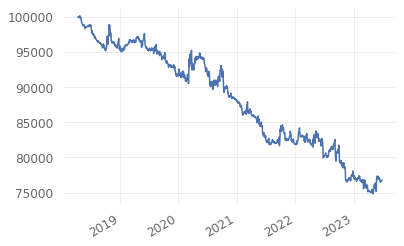

In [16]:
results.portfolio_value.plot()

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-13   2018-04-13
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             67.0%        100.0%

Cumulative Return          65.51%       -23.21%
CAGR﹪                     6.9%         -3.44%

Sharpe                     0.57         -0.9
Prob. Sharpe Ratio         90.9%        2.07%
Smart Sharpe               0.52         -0.82
Sortino                    0.85         -1.22
Smart Sortino              0.77         -1.11
Sortino/√2                 0.6          -0.86
Smart Sortino/√2           0.55         -0.79
Omega                      0.84         0.84

Max Drawdown               -27.32%      -25.28%
Longest DD Days            472          1891
Volatility (ann.)          20.62%       5.49%
R^2                        0.0          0.0
Information Ratio          -0.05        -0.05
Calmar        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-25,2023-05-01,2023-06-28,1891,-25.280809,-24.987593
2,2018-04-17,2018-04-20,2018-04-23,7,-0.126247,-0.112884


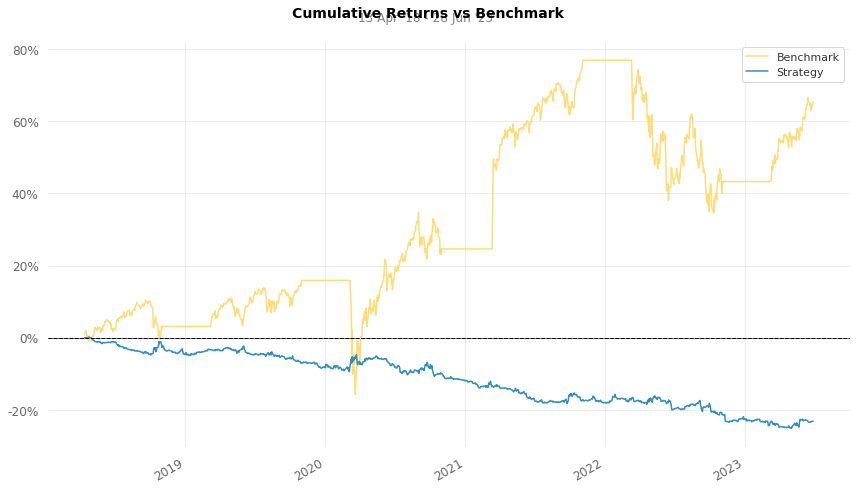

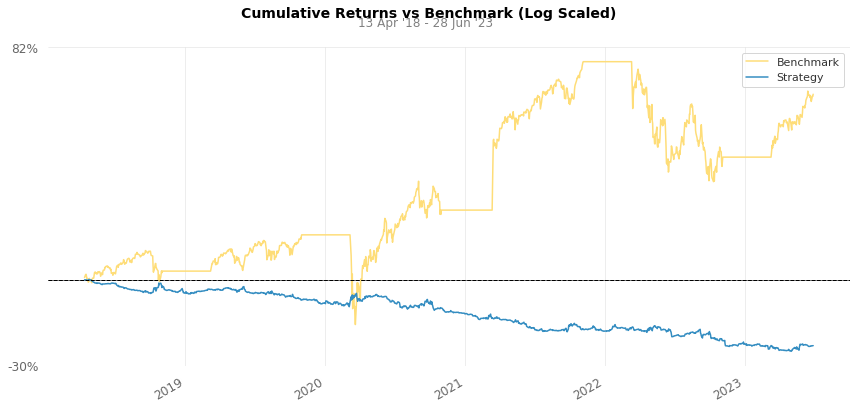

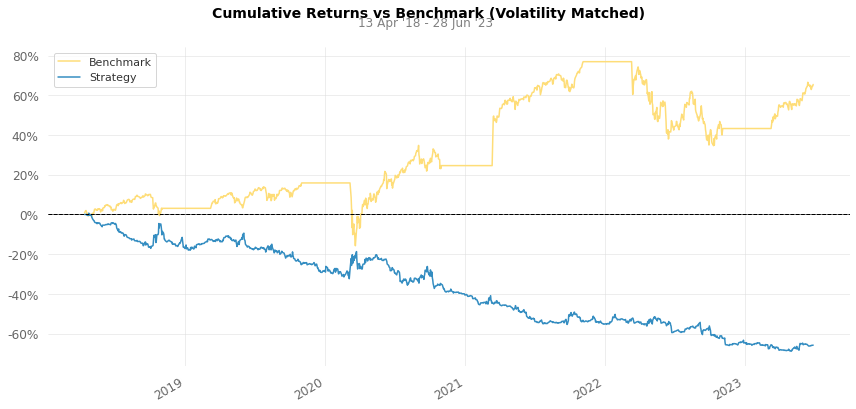

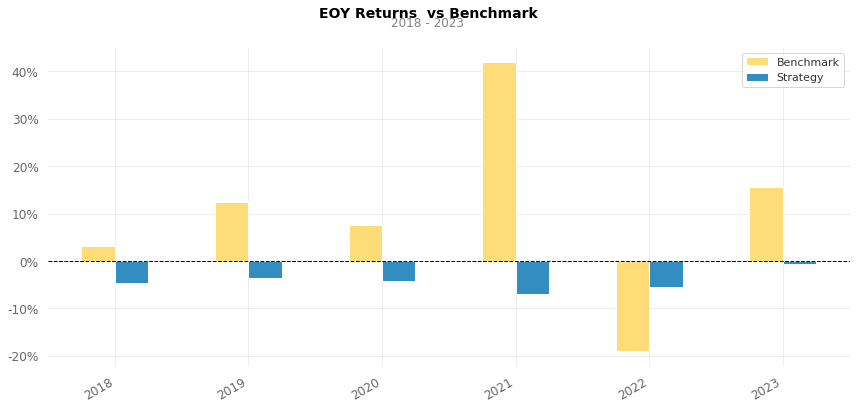

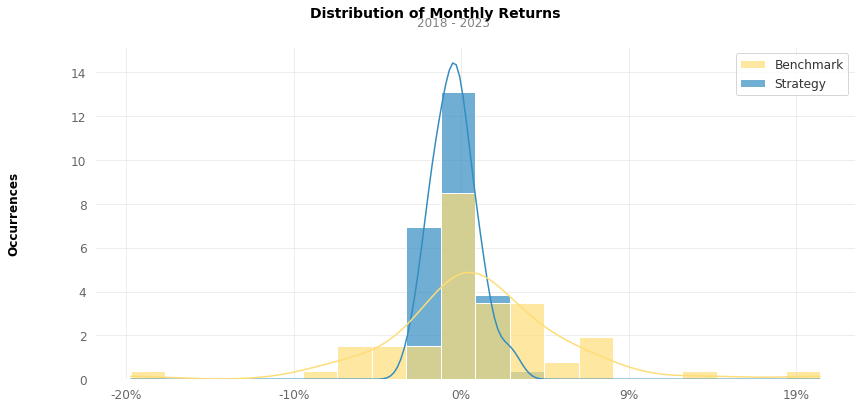

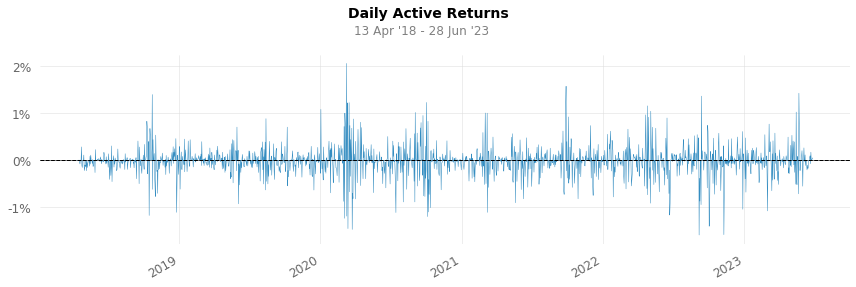

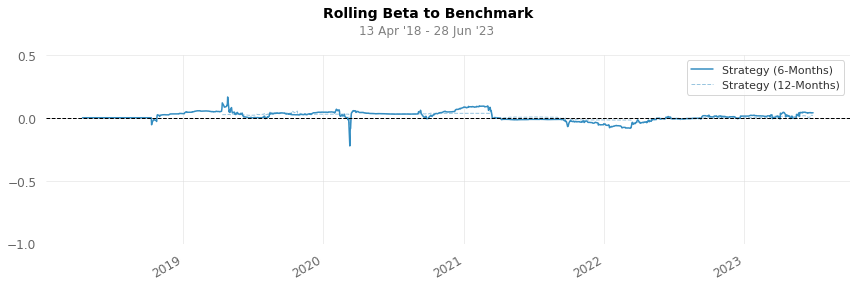

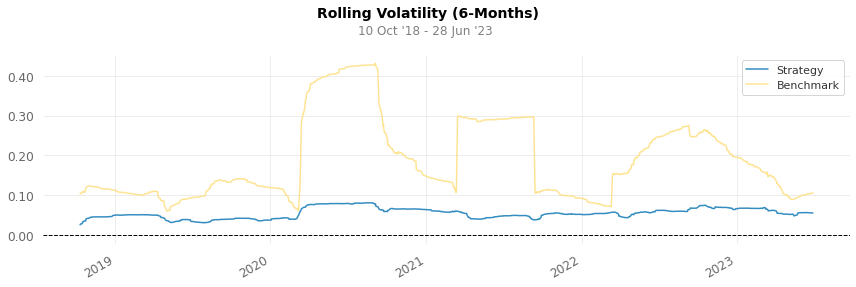

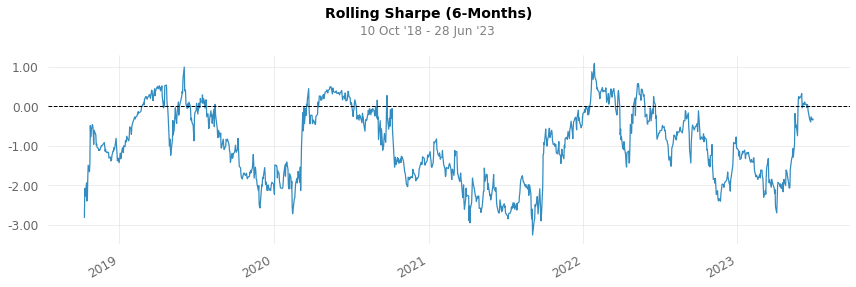

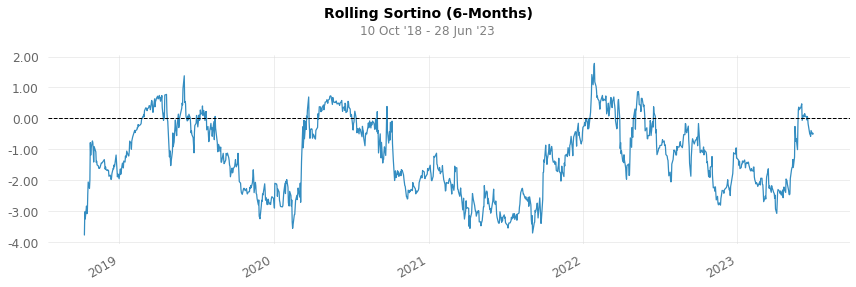

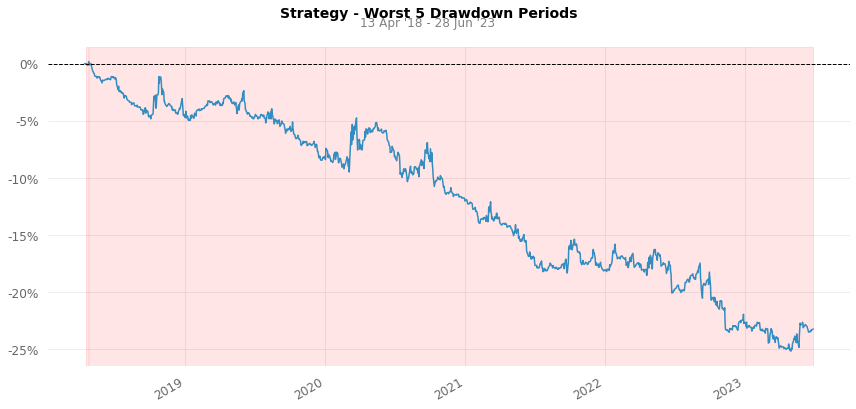

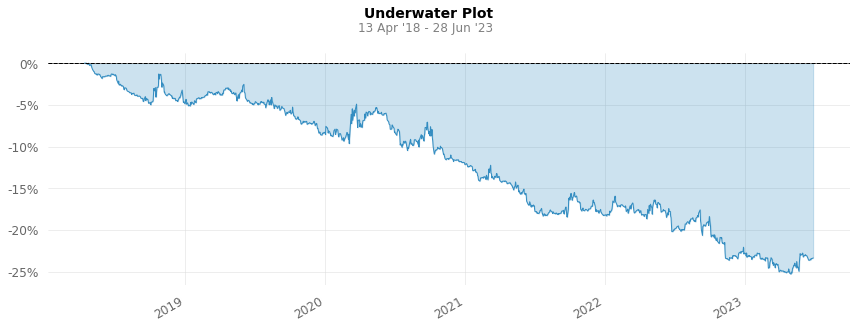

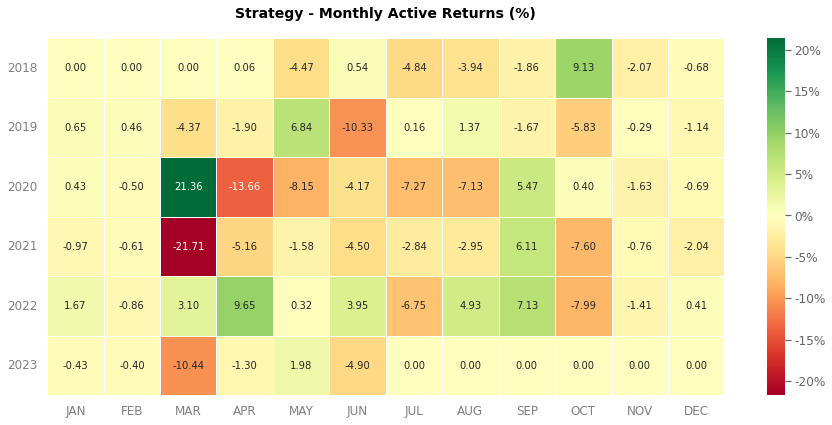

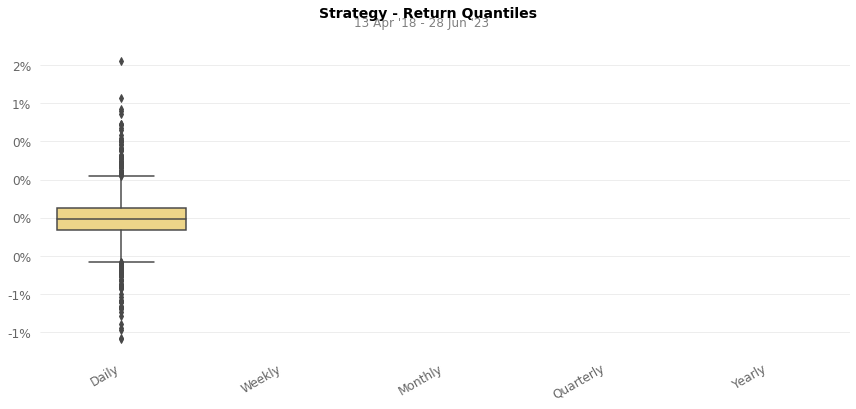

In [17]:
benchmark = qs.utils.download_returns('^GSPC', period="max")
results.index = pd.to_datetime(results.index).tz_convert(None)
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(12, 6))

# Bactest on single asset strategy

### ETNA Prophet

lets try with AAPL only with predicted and current SMA

In [37]:
AAPL =pd.read_csv('AAPL_etna_prophet.csv',index_col=0)
AAPL

,AAPL
timestamp,
2018-04-11,41.732859
2018-04-12,41.815973
2018-04-13,41.825633
2018-04-14,42.296707
2018-04-15,42.498866
...,...
2023-06-25,186.302304
2023-06-26,187.855436
2023-06-27,187.441287


In [68]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('AAPL_etna_prophet.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i=0

def handle_data(context, data):
    asset = symbol('AAPL')
    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'AAPL']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    
    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1    
    record(PRI=pricedic)

In [69]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL


[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             67.0%        98.0%

Cumulative Return          64.64%       1.22%
Active Return              0.0%         -63.42%
CAGR﹪                     6.87%        0.16%

Sharpe                     0.57         0.25
Prob. Sharpe Ratio         90.72%       71.25%
Smart Sharpe               0.54         0.23
Sortino                    0.84         0.36
Smart Sortino              0.8          0.34
Sortino/√2                 0.6          0.26
Smart Sortino/√2           0.56         0.24
Omega                      1.05         1.05

Max Drawdown               -27.32%      -2.53%
Longest DD Days            472          1192
Volatility (ann.)          20.66%       0.97%
R^2                        0.0          0.0
Information Ratio    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-24,2022-12-28,2023-06-28,1192,-2.532551,-2.513152
2,2018-11-26,2018-12-03,2018-12-06,11,-0.327881,-0.246114
3,2018-07-05,2018-10-03,2018-11-01,120,-0.309317,-0.269562
4,2019-06-04,2019-07-31,2019-10-31,150,-0.262674,-0.236881
5,2018-12-26,2019-01-02,2019-01-02,8,-0.256651,-0.252412


Slippage: 83.53500000000112
Slippage Lost: -18.212999999967252
Total Commission: 6.444000000000001


Average Long Exposure = 1373.1015856269107
Average Short Exposure = -1137.298750764526
Average Net Leverage = 0.00232728937529155
Average Gross Leverage = 0.024829607065436125
Max Leverage = 0.0757972209830316



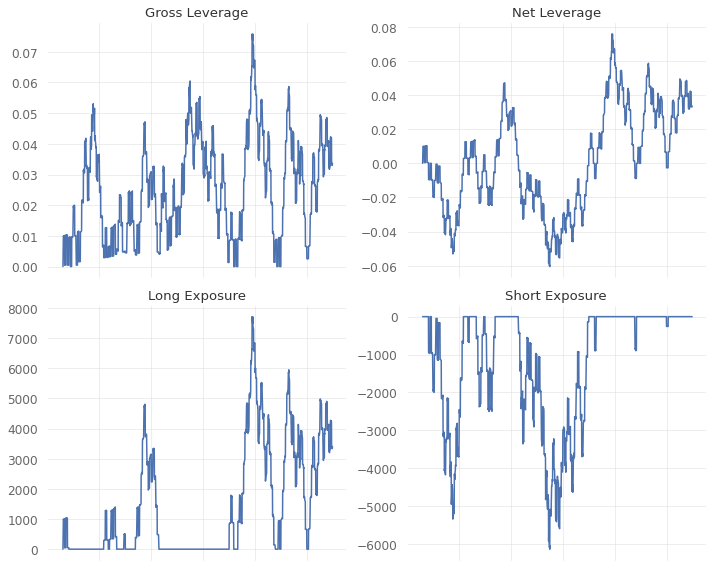

AAPL





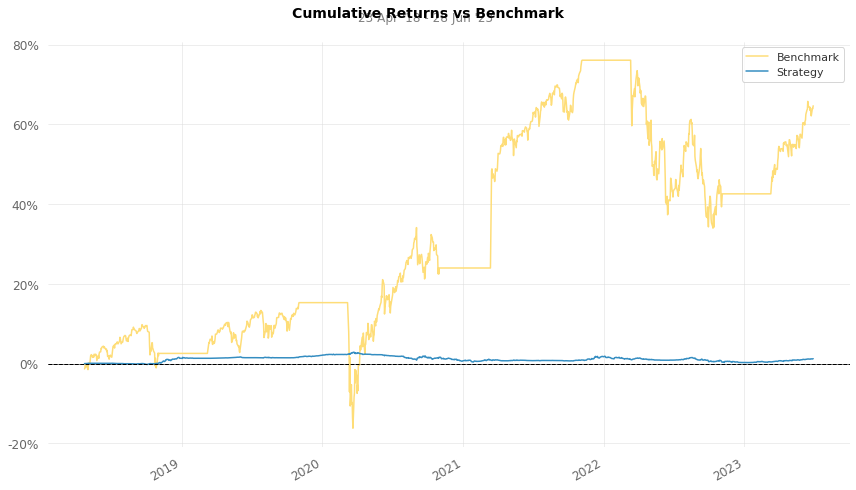

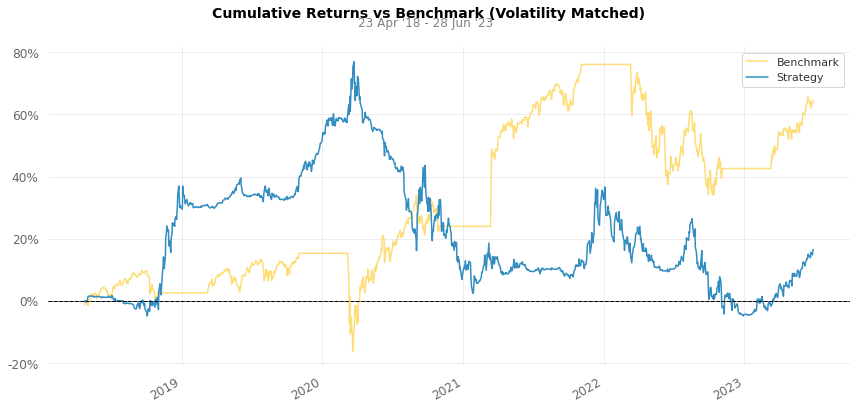

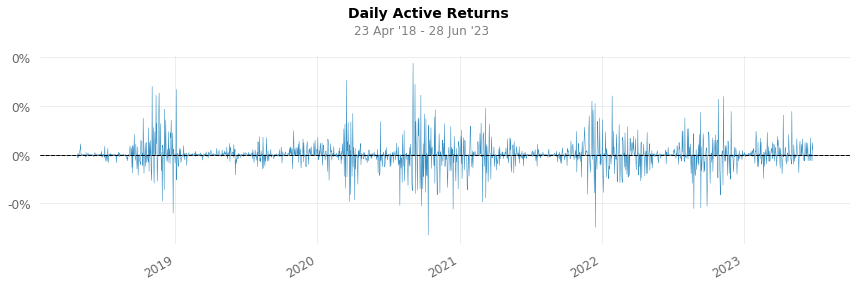

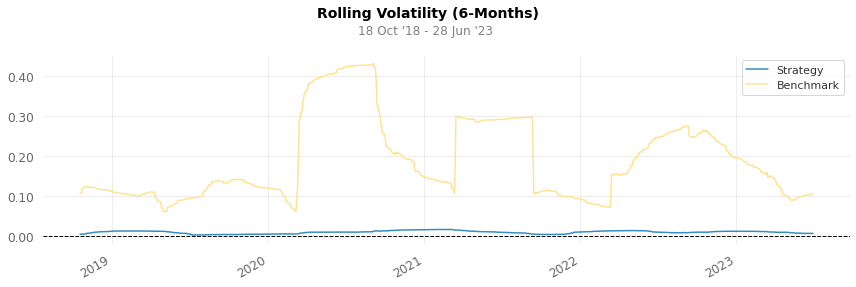

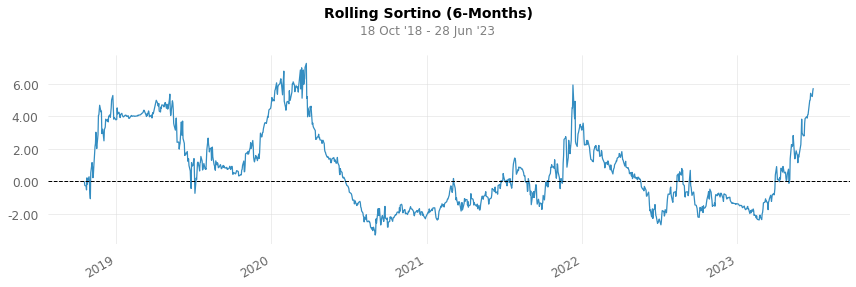

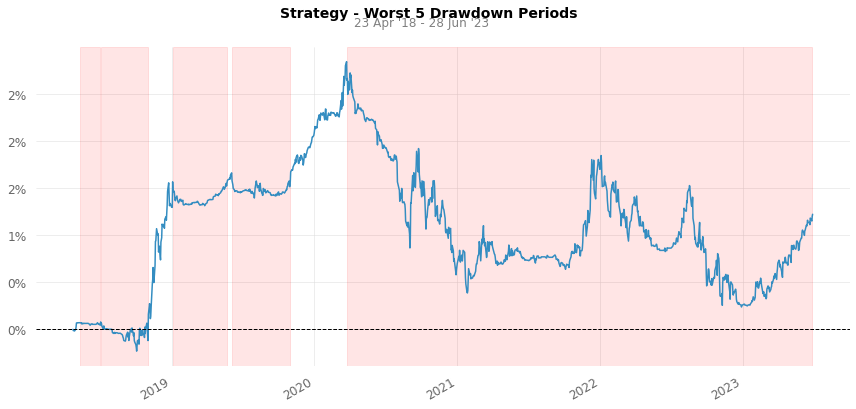

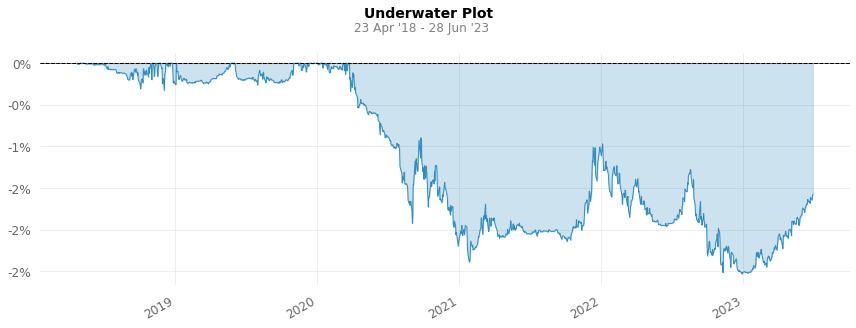

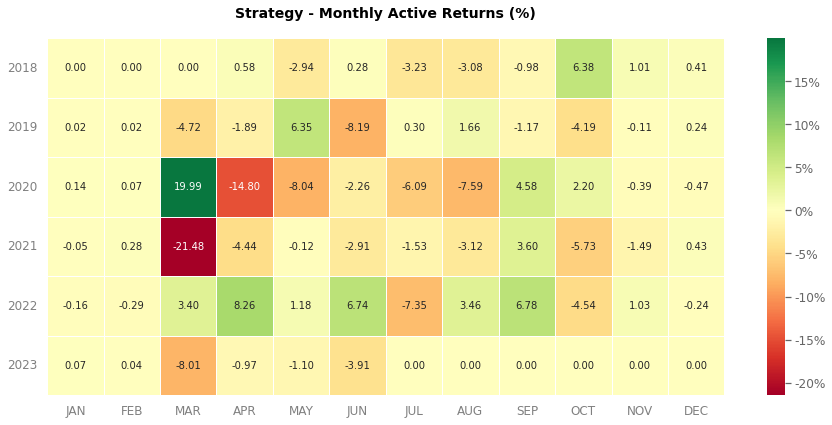

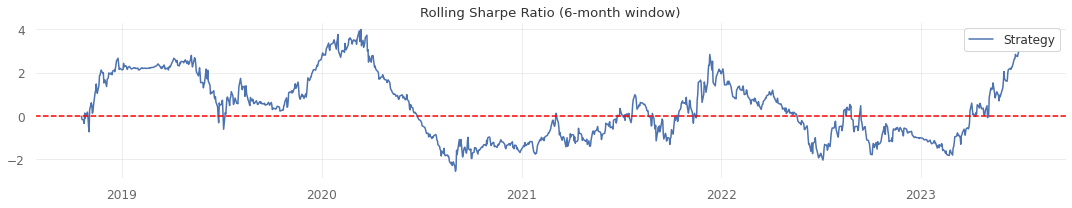

[*********************100%***********************]  1 of 1 completed


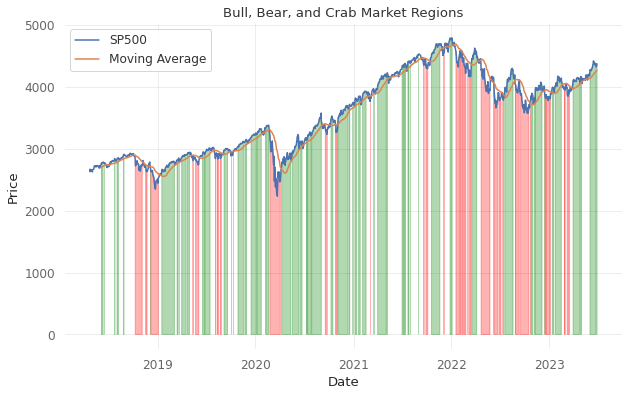

Total Trades: 187
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





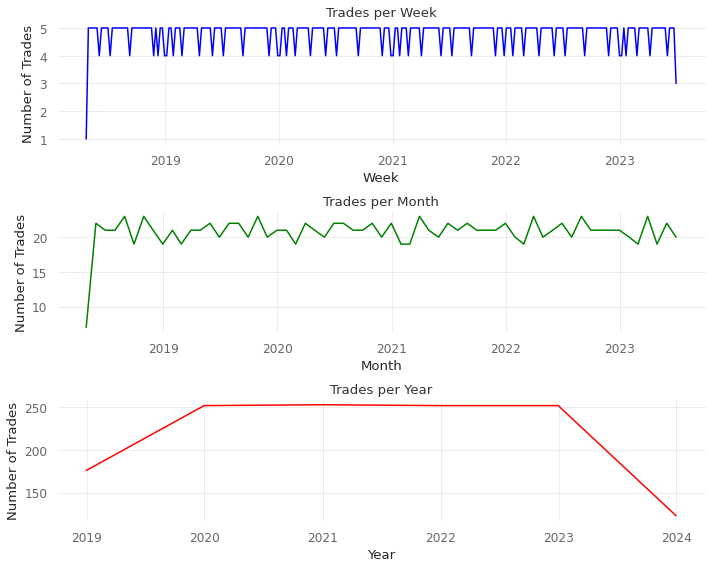

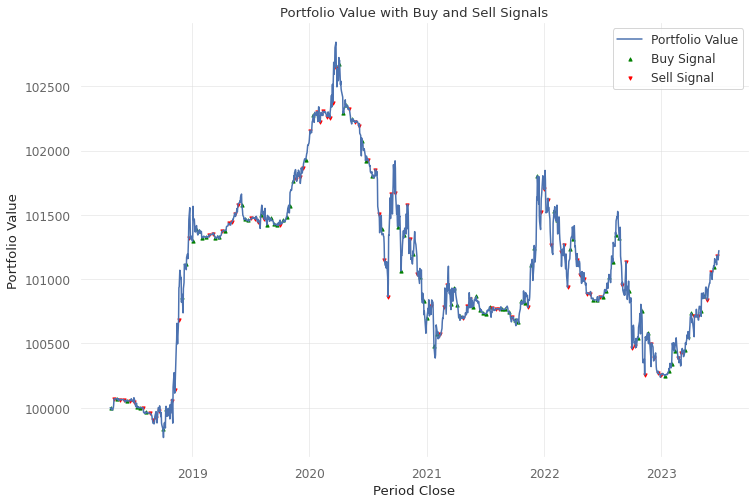

In [70]:
benchmark = qs.utils.download_returns('^GSPC', period="max")
results.index = pd.to_datetime(results.index).tz_convert(None)
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(12, 6),df=results)

### ETNA Catboost

In [41]:
AAPL =pd.read_csv('apple_by_catboost_etna.csv',index_col=0)
AAPL

,target
timestamp,
2018-04-11,43.404190
2018-04-12,43.321320
2018-04-13,43.432711
2018-04-14,43.567824
2018-04-15,43.617199
...,...
2023-06-25,185.247757
2023-06-26,186.712540
2023-06-27,185.203133


In [71]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('apple_by_catboost_etna.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0

def handle_data(context, data):
    asset = symbol('AAPL')

    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'target']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    

    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1 
        
    record(PRI=pricedic)

In [72]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Se

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             67.0%        100.0%

Cumulative Return          64.64%       22.01%
Active Return              0.0%         -42.63%
CAGR﹪                     6.87%        2.68%

Sharpe                     0.57         0.68
Prob. Sharpe Ratio         90.72%       93.81%
Smart Sharpe               0.55         0.65
Sortino                    0.84         0.99
Smart Sortino              0.81         0.95
Sortino/√2                 0.6          0.7
Smart Sortino/√2           0.57         0.67
Omega                      1.14         1.14

Max Drawdown               -27.32%      -9.43%
Longest DD Days            472          540
Volatility (ann.)          20.66%       5.93%
R^2                        0.0          0.0
Information Ratio    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-04,2023-01-05,2023-06-28,540,-9.429432,-8.822804
2,2021-01-27,2021-03-08,2021-07-13,167,-5.759151,-5.003659
3,2020-09-02,2020-09-18,2020-12-24,113,-5.382629,-5.291785
4,2021-09-08,2021-10-04,2021-11-17,71,-2.977564,-2.691449
5,2019-01-04,2020-03-23,2020-06-08,521,-2.778308,-2.587846


Slippage: 83.53500000000734
Slippage Lost: 21.289000000032573
Total Commission: 6.444000000000001


Average Long Exposure = 17518.920438837922
Average Short Exposure = -1001.6166100917434
Average Net Leverage = 0.14415852888445704
Average Gross Leverage = 0.16404630293605002
Max Leverage = 0.3202039288295417



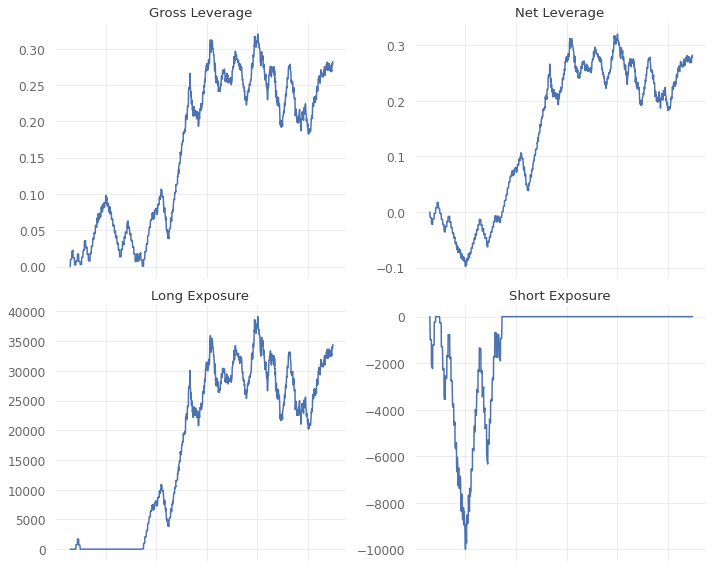

AAPL





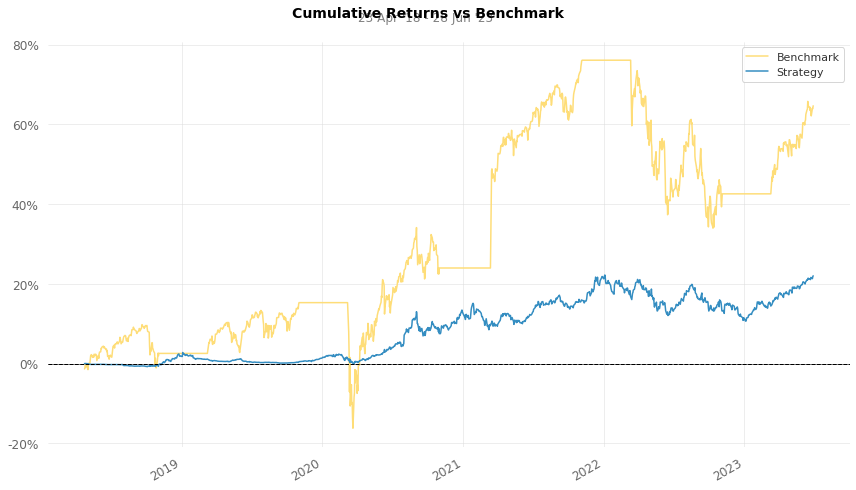

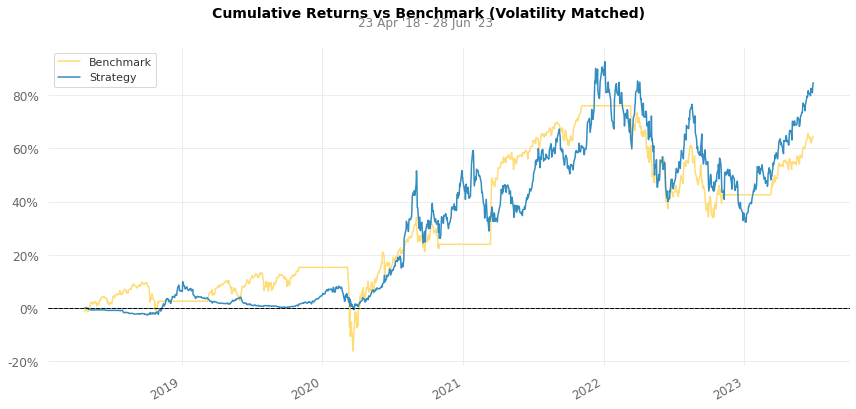

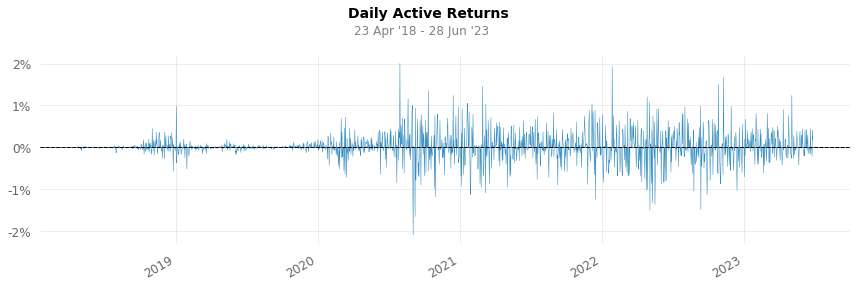

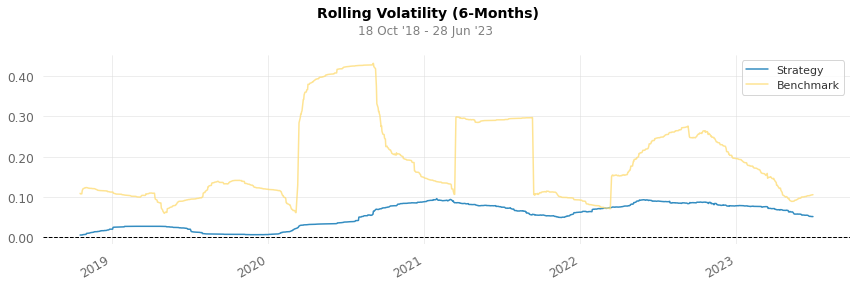

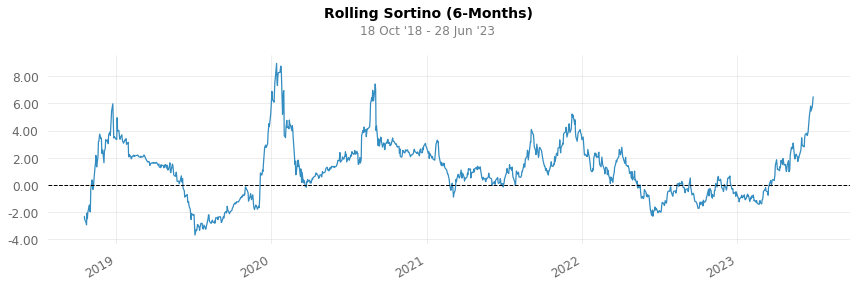

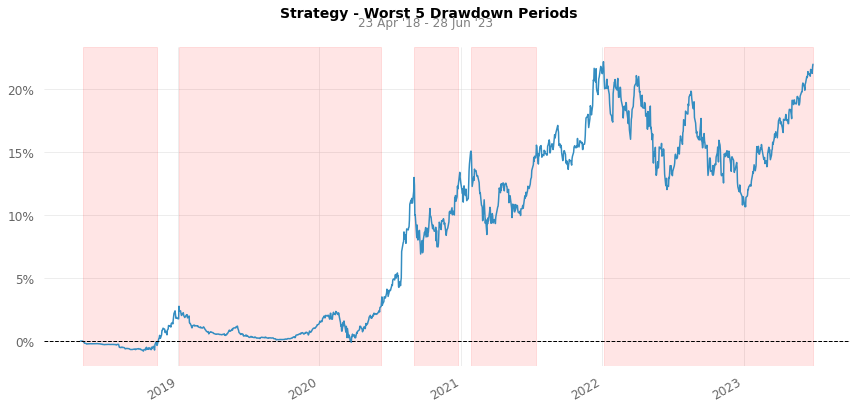

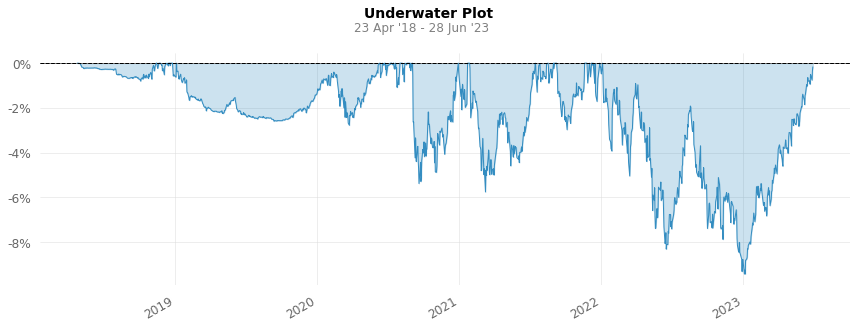

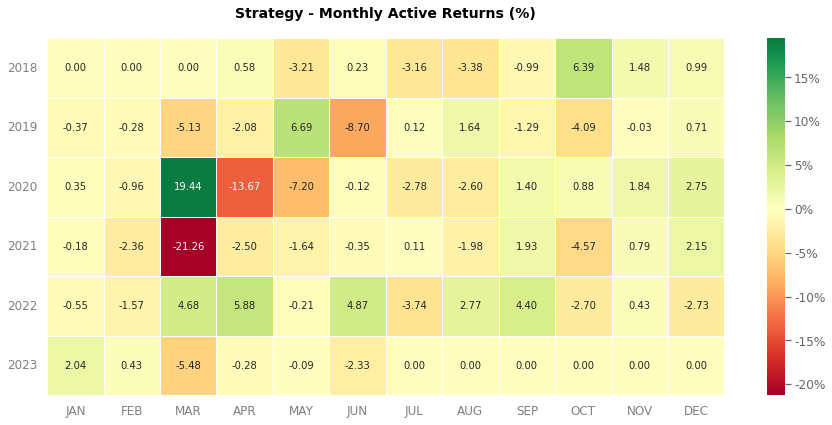

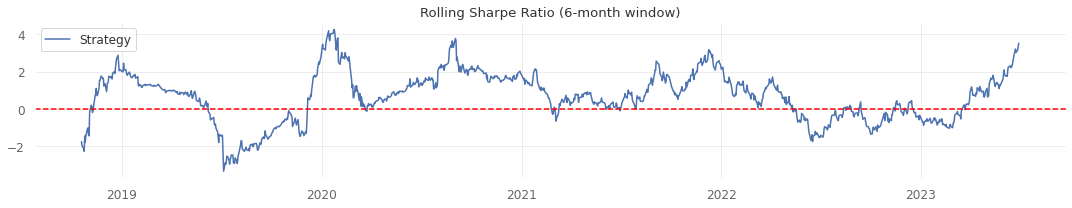

[*********************100%***********************]  1 of 1 completed


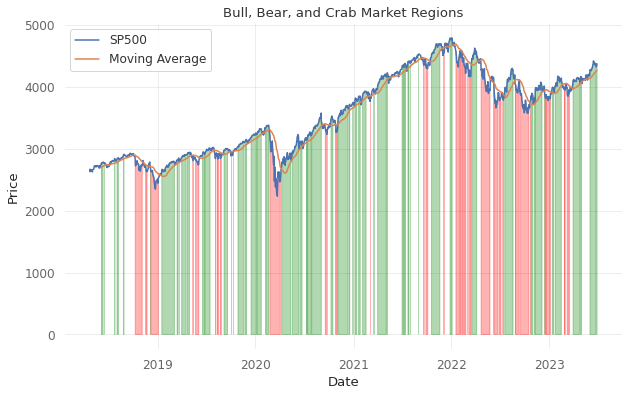

Total Trades: 187
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





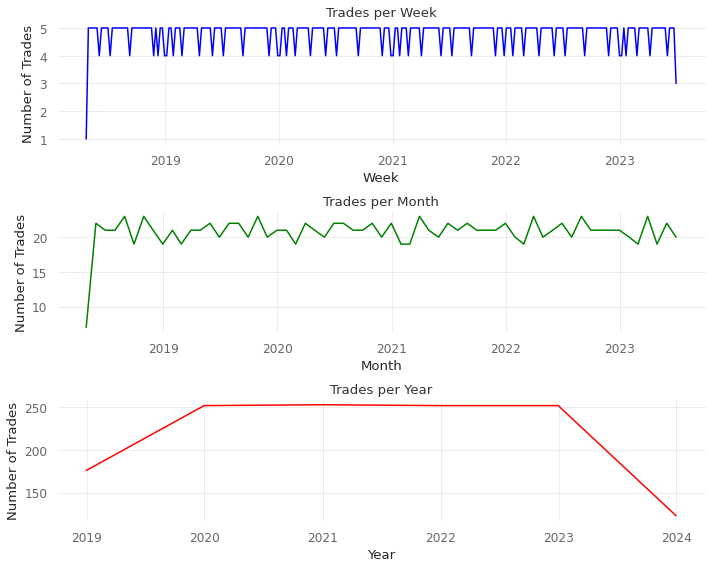

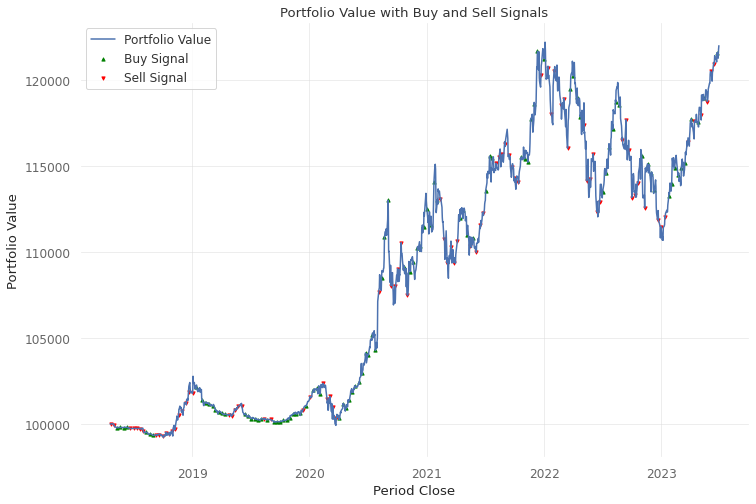

In [73]:
benchmark = qs.utils.download_returns('^GSPC', period="max")
results.index = pd.to_datetime(results.index).tz_convert(None)
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(12, 6),df=results)